# Analysis of Bacterial Mat Coverage

In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
import scipy
import scipy.misc
import scipy.cluster
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import MaxNLocator
import datetime
import os
import csv

#### Specify your inputs and example image. Images in frames/ have been extracted using scene 7 metadata from https://github.com/ooi-data-review/camhd_metadata/blob/master/scene_timing/zoom0_scenes.csv

In [2]:
NUM_CLUSTERS = 5
THRESHOLD = 200
SOURCE = '/Users/knuth/Documents/ooi/repos/old/CamHD_motion_metadata/datapackage/examples/output/d2_p7_z0/frames/'
IMAGE = '/Users/knuth/Documents/ooi/repos/old/CamHD_motion_metadata/datapackage/examples/output/d2_p7_z0/frames/00000000_CAMHDA301-20151201T210000Z_020571.png'

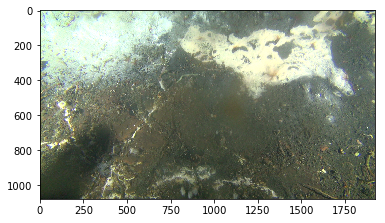

In [3]:
im = Image.open(IMAGE)
# im = im.resize((150, 150))      # optional, to reduce time
ar = scipy.misc.fromimage(im)
shape = ar.shape
ar = ar.reshape(scipy.product(shape[:2]), shape[2])
plt.imshow(im)

#### Find color clusters and pixel counts within each cluster. commenting in 'im = im.resize((150, 150))' above expedites this step

In [4]:
codes, dist = scipy.cluster.vq.kmeans(ar.astype(float), NUM_CLUSTERS)
codes = codes.astype(int)
vecs, dist = scipy.cluster.vq.vq(ar, codes)  # assign codes
counts, bins = scipy.histogram(vecs, len(codes))  # count occurrences
colors_dict = dict(zip(counts, codes))  # create dictionary of counts and codes

#### Show clustered image. The original image has been reduced to 5 clusters (NUM_CLUSTERS). The cluster with RGB values above 200 (THRESHOLD) represents the bacterial mat and will be selected in the final iteration below. 

pixel_count [R, G, B]
194674 [178 192 170]
320162 [128 138 121]
341110 [229 246 220]
564830 [63 69 54]
652824 [ 94 100  84]


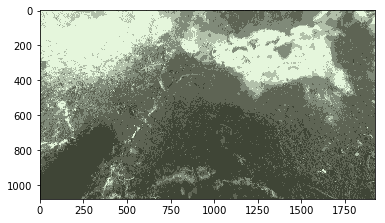

In [5]:
c = ar.copy()
for i, code in enumerate(codes):
    c[scipy.r_[scipy.where(vecs==i)],:] = code
scipy.misc.imsave('clusters.png', c.reshape(*shape))
im_clustered = Image.open('clusters.png', 'r')
plt.imshow(np.asarray(im_clustered))

print 'pixel_count [R, G, B]'
for key, value in sorted(colors_dict.iteritems()):
    print key, value

In [6]:
img = Image.open('clusters.png', 'r')
img = img.convert("RGBA")
datas = img.getdata()

newData = []
for item in datas:
    if item[0] > THRESHOLD and item[1] > THRESHOLD and item[2]  > THRESHOLD:
#         newData.append(item)
        newData.append((216, 232, 217, 255))
    else:
        newData.append((87, 93, 88, 255))

img.putdata(newData)
img.save("clusters_bac_mat.png", "PNG")

#### Loop through files to extract frames, cluster and plot the change in bacterial mat coverage percent over time.

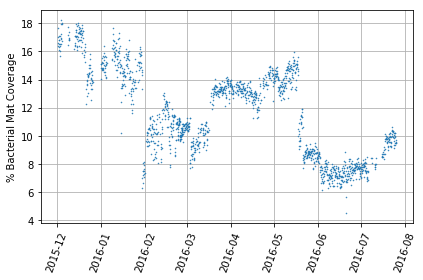

In [8]:
file_timestamp = []
bac_mat_size = []

for root, dirs, files in os.walk(SOURCE):
    for filename in files:
        if filename.endswith('.png'):
            file = os.path.join(root, filename)

            # read and resize image to reduce processing time
            im = Image.open(file)
            im = im.resize((150, 150))  # optional
            ar = scipy.misc.fromimage(im)
            shape = ar.shape
            ar = ar.reshape(scipy.product(shape[:2]), shape[2])

            # find clusters
            codes, dist = scipy.cluster.vq.kmeans(ar.astype(float), NUM_CLUSTERS)
            codes = codes.astype(int)
            vecs, dist = scipy.cluster.vq.vq(ar, codes)  # assign codes
            counts, bins = scipy.histogram(vecs, len(codes))  # count occurrences
            colors_dict = dict(zip(counts, codes))  # create dictionary of counts and codes   

            # extract time stampe from file name
            year = int(filename[19:23])
            month = int(filename[23:25])
            day = int(filename[25:27])
            hour = int(filename[28:30])
            minute = int(filename[30:32])
            dt = datetime.datetime(year, month, day, hour, minute)

            total = 0

            for key, value in colors_dict.iteritems():
                total = total + key
            for key, value in colors_dict.iteritems():
                if all(i > THRESHOLD for i in value):
                    size_percent = float(key) / float(total) * 100
                    bac_mat_size.append(size_percent)
                    file_timestamp.append(dt)


        
        
fig, ax = plt.subplots();
plt.plot(file_timestamp, bac_mat_size, linestyle='None', marker='.', markersize=1)
plt.xticks(rotation=70)
plt.ylabel('% Bacterial Mat Coverage')
plt.grid()
# plt.gcf().subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.savefig('fig.png', dpi = 300)
plt.show()

In [9]:
x = zip(file_timestamp, bac_mat_size)

with open('data/bac_mat_data.csv', 'wb') as myfile:
    wr = csv.writer(myfile)
    for i in x:
        wr.writerow(i)